In [10]:
import numpy as np
import pandas as pd
import scipy.signal as ss

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
data = pd.read_csv('../data/hbv_s_data.csv', index_col=0, parse_dates=True)

In [12]:
data.head(3)

,Prec,Qobs,Temp,Evap
2001-10-01,0.0,0.13607,8.1,0.4
2001-10-02,0.0,0.13791,8.6,0.4
2001-10-03,0.0,0.13795,6.0,0.4


In [303]:
def hbv_simulation(data, params):
    '''
    Implementation of HBV model (Bergstrom, 1986)
    
    Input: 
    1. data 
    pandas dataframe with columns 'Temp', 'Prec', 'Evap'
    assosiated with correspondent daily time series derived 
    from WFDEI meteorological forcing dataset.
    'Temp' - Celsius degrees
    'Prec' - mm/day
    'Evap' - mm/day
    2. params
    List of 16 HBV model parameters
    [parBETA, parCET,  parFC,    parK0, 
    parK1,    parK2,   parLP,    parMAXBAS,
    parPERC,  parUZL,  parPCORR, parTT, 
    parCFMAX, parSFCF, parCFR,   parCWH]
    
    init_params = [ 1.0,   0.15,    250,   0.055, 
                    0.055, 0.04,    0.7,   3.0,
                    1.5,   120,     1.0,   0.0, 
                    5.0,   0.7,     0.05,  0.1]
    # 16 parameters
    # BETA   - parameter that determines the relative contribution to runoff from rain or snowmelt 
    #          [1, 6]
    # CET    - Evaporation correction factor 
    #          (should be 0 if we don't want to change (Oudin et al., 2005) formula values) 
    #          [0, 0.3]
    # FC     - maximum soil moisture storage
    #          [50, 500]
    # K0     - recession coefficient for surface soil box (upper part of SUZ)
    #          [0.01, 0.4]
    # K1     - recession coefficient for upper groudwater box (main part of SUZ)
    #          [0.01, 0.4]
    # K2     - recession coefficient for lower groudwater box (whole SLZ)
    #          [0.001, 0.15]
    # LP     - Threshold for reduction of evaporation (SM/FC)
    #          [0.3, 1]
    # MAXBAS - routing parameter, order of Butterworth filter
    #          [1, 7]
    # PERC   - percolation from soil to upper groundwater box
    #          [0, 3]
    # UZL    - threshold parameter for grondwater boxes runoff (mm) 
    #          [0, 500]
    # PCORR  - Precipitation (input sum) correction factor
    #          [0.5, 2]
    # TT     - Temperature which separate rain and snow fraction of precipitation 
    #          [-1.5, 2.5]
    # CFMAX  - Snow melting rate (mm/day per Celsius degree) 
    #          [1, 10]
    # SFCF   - SnowFall Correction Factor 
    #          [0.4, 1]
    # CFR    - Refreezing coefficient 
    #          [0, 0.1] (usually 0.05)
    # CWH    - Fraction (portion) of meltwater and rainfall which retain in snowpack (water holding capacity)
    #          [0, 0.2] (usually 0.1)
    
    Output:
    simulated river runoff (daily timestep)
    '''
    # 1. read input data
    Temp = data['Temp']
    Prec = data['Prec']
    Evap = data['Evap']
    
    # 2. set the parameters
    parBETA, parCET, parFC, parK0, parK1, parK2, parLP, parMAXBAS,\
    parPERC, parUZL, parPCORR, parTT, parCFMAX, parSFCF, parCFR, parCWH = params
    
    # 3. initialize boxes and initial conditions
    # snowpack box
    SNOWPACK = np.zeros(len(Prec))
    SNOWPACK[0] = 0.0001
    # meltwater box
    MELTWATER = np.zeros(len(Prec))
    MELTWATER[0] = 0.0001
    # soil moisture box
    SM = np.zeros(len(Prec))
    SM[0] = 0.0001
    # soil upper zone box
    SUZ = np.zeros(len(Prec))
    SUZ[0] = 0.0001
    # soil lower zone box
    SLZ = np.zeros(len(Prec))
    SLZ[0] = 0.0001
    # actual evaporation
    ETact = np.zeros(len(Prec))
    ETact[0] = 0.0001
    # simulated runoff box
    Qsim = np.zeros(len(Prec))
    Qsim[0] = 0.0001
    
    # 4. meteorological forcing preprocessing
    # overall correction factor
    Prec = parPCORR * Prec
    # precipitation separation
    # if T < parTT: SNOW, else RAIN
    RAIN = np.where(Temp  > parTT, Prec, 0)
    SNOW = np.where(Temp <= parTT, Prec, 0)
    # snow correction factor
    SNOW = parSFCF * SNOW
    # evaporation correction
    # a. calculate long-term averages of daily temperature
    Temp_mean = np.array([Temp.ix[Temp.index.dayofyear == x].mean()\
                          for x in range(1, 367)])
    # b. correction of Evaporation daily values
    Evap = Evap.index.map(lambda x: (1+parCET*(Temp[x] - Temp_mean[x.dayofyear - 1]))*Evap[x])
    # c. control Evaporation
    Evap = np.where(Evap > 0, Evap, 0)
    
    
    # 5. The main cycle of calculations
    for t in range(1, len(Qsim)):
        
        # 5.1 Snow routine
        # how snowpack forms
        SNOWPACK[t] = SNOWPACK[t-1] + SNOW[t]
        # how snowpack melts
        # day-degree simple melting
        melt = parCFMAX * (Temp[t] - parTT)
        # control melting
        if melt<0: melt = 0
        melt = min(melt, SNOWPACK[t])
        # how meltwater box forms
        MELTWATER[t] = MELTWATER[t-1] + melt
        # snowpack after melting
        SNOWPACK[t] = SNOWPACK[t] - melt
        # refreezing accounting
        refreezing = parCFR * parCFMAX * (parTT - Temp[t])
        # control refreezing
        if refreezing < 0: refreezing = 0
        refreezing = min(refreezing, MELTWATER[t])
        # snowpack after refreezing
        SNOWPACK[t] = SNOWPACK[t] + refreezing 
        # meltwater after refreezing
        MELTWATER[t] = MELTWATER[t] - refreezing
        # recharge to soil
        tosoil = MELTWATER[t] - (parCWH * SNOWPACK[t]);
        # control recharge to soil
        if tosoil < 0: tosoil = 0
        # meltwater after recharge to soil
        MELTWATER[t] = MELTWATER[t] - tosoil
        
        # 5.2 Soil and evaporation routine
        # soil wetness calculation
        soil_wetness = (SM[t-1] / parFC)**parBETA
        # control soil wetness (should be in [0, 1])
        if soil_wetness < 0: soil_wetness = 0
        if soil_wetness > 1: soil_wetness = 1
        # soil recharge
        recharge = (RAIN[t] + tosoil) * soil_wetness
        # soil moisture update
        SM[t] = SM[t-1] + RAIN[t] + tosoil - recharge
        # excess of water calculation
        excess = SM[t] - parFC
        # control excess
        if excess < 0: excess = 0
        # soil moisture update
        SM[t] = SM[t] - excess
        
        # evaporation accounting
        evapfactor = SM[t] / (parLP * parFC)
        # control evapfactor in range [0, 1]
        if evapfactor < 0: evapfactor = 0
        if evapfactor > 1: evapfactor = 1
        # calculate actual evaporation
        ETact[t] = Evap[t] * evapfactor
        # control actual evaporation
        ETact[t] = min(SM[t], ETact[t])
        
        # last soil moisture updating
        SM[t] = SM[t] - ETact[t]
        
        # 5.3 Groundwater routine
        # upper groudwater box
        SUZ[t] = SUZ[t-1] + recharge + excess
        # percolation control
        perc = min(SUZ[t], parPERC)
        # update upper groudwater box
        SUZ[t] = SUZ[t] - perc
        # runoff from the highest part of upper grondwater box (surface runoff)
        Q0 = parK0 * max(SUZ[t] - parUZL, 0)
        # update upper groudwater box
        SUZ[t] = SUZ[t] - Q0
        # runoff from the middle part of upper groundwater box
        Q1 = parK1 * SUZ[t]
        # update upper groudwater box
        SUZ[t] = SUZ[t] - Q1
        # calculate lower groundwater box
        SLZ[t] = SLZ[t-1] + perc
        # runoff from lower groundwater box
        Q2 = parK2 * SLZ[t]
        # update lower groundwater box
        SLZ[t] = SLZ[t] - Q2
        
        # Total runoff calculation
        Qsim[t] = Q0 + Q1 + Q2
    
    # 6. Scale effect accounting
    # delay and smoothing simulated hydrograph
    # (Beck et al.,2016) used triangular transformation based on moving window
    # here are my method with simple forward filter based on Butterworht filter design
    # calculate Numerator (b) and denominator (a) polynomials of the IIR filter
    b, a = ss.butter(parMAXBAS, 1/parMAXBAS)
    # implement forward filter
    Qsim_smoothed = ss.lfilter(b, a, Qsim)
    # control smoothed runoff
    Qsim_smoothed = np.where(Qsim_smoothed > 0, Qsim_smoothed, 0)
    
    Qsim = Qsim_smoothed
    
    return Qsim

In [304]:
#parBETA,  parCET,  parFC,    parK0, 
#parK1,    parK2,   parLP,    parMAXBAS,
#parPERC,  parUZL,  parPCORR, parTT, 
#parCFMAX, parSFCF, parCFR,   parCWH]
init_params =\
[1.0,   0.15,    250,  0.055,
 0.055,  0.04,   0.7,  3.0,
 1.5,   120,     1.0,  0.0, 
 5.0,   0.7,     0.05, 0.1]

In [305]:
Qsim = hbv_simulation(data, init_params)

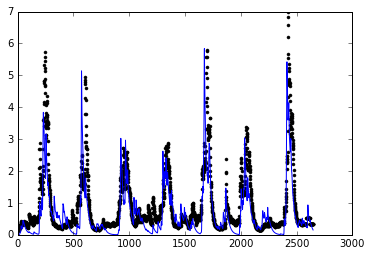

In [306]:
plt.plot(range(len(Qsim)), data.Qobs, '.k',
         range(len(Qsim)), Qsim, '-b')

In [299]:
hbv_simulation?

In [300]:
import sys
sys.path.append('../models/')
from hbv import simulation

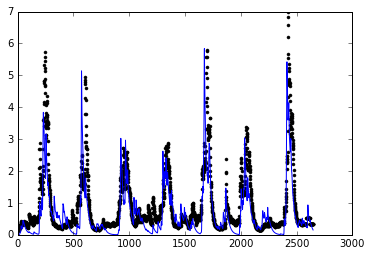

In [302]:
plt.plot(range(len(Qsim)), data.Qobs, '.k',
         range(len(Qsim)), simulation(data), '-b')

# export works fine

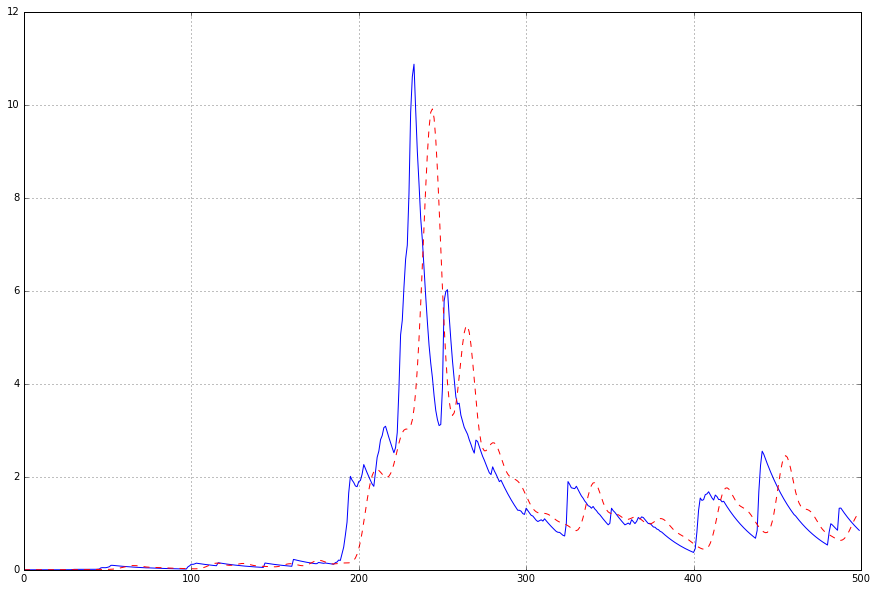

In [253]:
# Butterworth and forward filter scheme
import scipy.signal as ss
maxbas = 7
b, a = ss.butter(maxbas, 1/maxbas)
Qsim_sm = ss.lfilter(b, a, Qsim)

plt.figure(figsize=(15, 10))
plt.plot(range(len(Qsim))[0:500], Qsim[0:500], '-b', 
         range(len(Qsim_sm))[0:500], Qsim_sm[0:500], '--r')
plt.grid()

In [153]:
# Hylke Beck implementation

parMAXBAS = 5
parMAXBAS = np.round(parMAXBAS*100)/100
Qsim_smoothed = np.zeros(len(Qsim))
window = parMAXBAS * 100

for i in range(len(Qsim)-1, -1, -1):
    window = parMAXBAS * 100
    w = np.zeros(window)
    for x in range(int(window)):
        w[x] = window/2 - np.abs(window/2 - x + 0.5)
    w = np.hstack((w, np.zeros(200)))
    w_small = np.zeros(np.ceil(parMAXBAS))
    for y in range(int(np.ceil(parMAXBAS))):
        w_small[y] = np.sum(w[y*100-99 : y*100])
    w_small = w_small / w_small.sum()
    for bb in range(len(w_small)):
        Qsim_smoothed[bb:len(Qsim_smoothed)] =+ Qsim[0:len(Qsim_smoothed)-bb]*w_small[bb]

/home/hydrogo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/hydrogo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


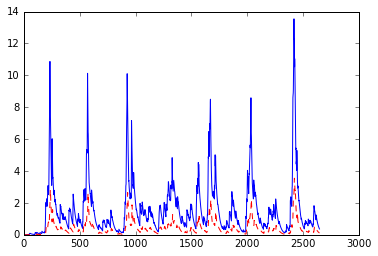

In [155]:
plt.plot(range(len(Qsim)), Qsim, '-b', 
         range(len(Qsim_smoothed)), Qsim_smoothed, '--r')